# Further Ideas: Music Generation with Variational AutoEncoder (VAE)

Music often follows different patterns. Some are predictable, some are to complex to grasp. To inspect the idea of repetition and the usefulness of the architecture of an RNN, a Variational AutoEncoder (VAE) was depicted. This offered a comparison of the generation of music with different architectures and losses.

Thereby this [tutorial on VAE music generation](https://www.kaggle.com/code/basu369victor/generate-music-with-variational-autoencoder#What-is-Variational-AutoEncoder?)was used as inspiration.

The music21 structure was used from the official notebook, while the model was changed to VAE.

| Teammember |                    |
|------------|--------------------|
| 1.         | Nadine Weber    |
| 2.         | Patrick Singer      |
| 3.         | Milos Aleksic         |
---

<font color="blue">
All added comments from us will be marked in blue color.</font>

### Introduction to VAE Music Generation
#### Theoretical Background
VAE is an autoencoder and consists of an encoder- and decoder-module. The encoder outputs a latent representation - a combined form of the input data. The decoder should be able to reconstruct the original input from this latent representation. Often times, the reconstruction isn't lossless. This is especially interesting for music generation, as a lossy compressing of music might be difficult.

A Variational Autoencoder (not the autoencoder itself) is a generative model which can generate new objects. This is why we tested it in comparison to the RNN approach. With the parameters mean and standard deviation of a probabilty distribution, new samples can be generated corresponding to this distribution. Thereby the input is not mapped to a latent distribution but to the probability distribution in particular. The process of parameter estimation and sampling is in the latent layer. The weights are learned by minimising a loss-function, which measures the difference between the reconstruction and the original. Standard gradient descent and backpropagation can be applied.

#### Hypotheses
We predict that the latent space isn't broad enough to capture the complexity of music. It might be okay for easy pieces, like music for kids, but not for complex music by famous composers.

Whike RNNs take time-series input to predict the future, a VAE processes the latent representation of the input data in no time-dependent order. It will be interesting to invest on if the learning is possible.

The theoretical background can be further inspected in the [ML lecture](https://hannibunny.github.io/mlbook/neuralnetworks/04VariationalAutoencoder.html).

<font color="blue">As the code mostly resembles the original GAN structure, comments were only added in places where we made changes to avoid repitition.</font>

### Now back to the music...

In [39]:
import music21
import os
import copy
import time
import random
import tensorflow as tf
from datetime import datetime

tf.config.run_functions_eagerly(True)
#tf.data.experimental.enable_debug_mode()

#### Load example file & print file structure

In [40]:
test_file = "./midi_files/mozart/mz_311_1.mid"
midi_file = music21.converter.parse(test_file)

for part in midi_file.parts:
    print(part.partName)
    for measure in part.getElementsByClass('Measure'):  # Measure = Takt
        # print the measure number and contents
        print('Measure', measure.number)
        measure.show('text')

/opt/miniconda3/envs/myenv3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Piano right
Measure 1
{0.0} <music21.instrument.Piano 'Piano right: Piano right'>
{0.0} <music21.instrument.Piano 'Piano'>
{0.0} <music21.clef.TrebleClef>
{0.0} <music21.tempo.MetronomeMark allegrissimo Quarter=141.83>
{0.0} <music21.key.Key of D major>
{0.0} <music21.meter.TimeSignature 4/4>
{0.0} <music21.chord.Chord A4 D5 F#4>
{1.0} <music21.note.Rest quarter>
{2.0} <music21.tempo.MetronomeMark Quarter=147.83>
{2.0} <music21.note.Note G>
{2.25} <music21.note.Note F#>
{2.5} <music21.note.Note E>
{2.75} <music21.note.Note F#>
{3.0} <music21.note.Note A>
{3.25} <music21.note.Note G>
{3.5} <music21.tempo.MetronomeMark Quarter=135.83>
{3.5} <music21.note.Note F#>
{3.75} <music21.note.Note G>
Measure 2
{0.0} <music21.tempo.MetronomeMark Quarter=148.83>
{0.0} <music21.note.Note A>
{1.0} <music21.tempo.MetronomeMark Quarter=146.83>
{1.0} <music21.note.Rest quarter>
{2.0} <music21.tempo.MetronomeMark Quarter=148.83>
{2.0} <music21.note.Note A>
{2.25} <music21.note.Rest 16th>
{2.5} <music21.n

#### Show track in inline player

In [41]:
midi_file = music21.converter.parse(test_file)
midi_file.show("midi")

<font color="blue"><h5>FUNCTION: Extract Notes</h5></font>
Takes a loaded midi file and returns a list for notes and for durations. Notes, Rests and Chords are considered. This function was initially only extracting notes and chords. It was later expanded to also extract pauses (rests) and the durations for every element.
* `include_rests` = Include rests in the output lists
* `only_first_part` = If true, only returns notes from the main part (Erste Stimme)
* `normalize_chords` = If true, chords are saved without the octaves of their notes

In [42]:
def extract_notes(midi_file, include_rests=False, only_first_part=False, normalize_chords=True):
    # Save note and durations separately
    notes = [] # Saves Notes as "C4", Chords as "D4_A2" and Pauses as "P"
    durations = [] # Saves one duration for every element in notes

    # Determine if all parts or only first part included
    iterator_obj = midi_file.getElementsByClass("Part")[0].recurse() if only_first_part else midi_file.recurse()
    # iterator_obj = midi_file.getElementsByClass("Part")[0].flat.elements if only_first_part else midi_file.flat.elements

    # Filter elements for Notes, Chords and Rests
    for element in iterator_obj:
        # TYPE: Rest
        if type(element) == music21.note.Rest and include_rests:
            notes.append("P")
            durations.append(float(element.quarterLength))
        # TYPE: Note
        elif type(element) == music21.note.Note:
            notes.append(element.nameWithOctave)
            durations.append(float(element.quarterLength))
        # TYPE: Chord
        elif type(element) == music21.chord.Chord:
            chord_notes = [note.name if normalize_chords else note.nameWithOctave for note in element.notes]
            notes.append("_".join(chord_notes))
            durations.append(float(element.quarterLength))
    
    return notes, durations

<font color="blue"><h5>FUNCTION: Extract Notes from MIDI Files</h5></font>
Loads all midi files in a given folder and converts them to a notes and durations list using the **extract_notes** function
* `include_rests`, `only_first_part`, `normalize_chords` = See **extract_notes** function
* `flatten_list` = If true, returns only one list. If false, one list per track
* `verbose` = Print information about loaded data
* `limit` = Limits the read files (This was included to test configurations faster, as the loading of many midi files takes a long time)

In [43]:
def extract_notes_from_midi_files(folder_path, include_rests=False, only_first_part=False, normalize_chords=True, flatten_list=True, verbose=True, limit=100):
    # Save notes and durations separately
    files_notes = []
    files_durations = []

    #Parse all midi files
    for file in os.listdir(folder_path)[:limit if len(os.listdir(folder_path)) > limit else len(os.listdir(folder_path))]:
        if file.endswith(".mid"):
            try:
                midi_file = music21.converter.parse(folder_path + "/" + file)
                notes, durations = extract_notes(midi_file, include_rests=include_rests, only_first_part=only_first_part, normalize_chords=normalize_chords)

                files_notes.append(notes)
                files_durations.append(durations)
            except:
                print("Skipping corrupted midi file", file)
    
    # Flatten to one list, if flatten_list is True
    if flatten_list:
        files_notes = [item for sublist in files_notes for item in sublist]
        files_durations = [item for sublist in files_durations for item in sublist]
    
    # Print information
    if verbose:
        flatten_placeholder = [item for sublist in files_notes for item in sublist]
        print(f"Loaded notes from {len(os.listdir(folder_path))} midi files")
        print(f"Total number of notes: {len(files_notes) if flatten_list else len(flatten_placeholder)}")
        print(f"Number of unique notes: {len(set(files_notes)) if flatten_list else len(set(flatten_placeholder))}") 
              
    return files_notes, files_durations

<font color="blue"><h5>FUNCTION: Create MIDI</h5></font>
Creates a music21 Stream object that can be played in the inline player.
* `notes` = List of notes
* `durations` = List of durations, if none given, defaults to a quarter

In [44]:
def create_midi(notes, durations=None):
    if durations is None:
        durations = [.5]*len(notes)

    stream = music21.stream.Stream()

    for i, element in enumerate(notes):
        # TYPE: Rest
        if element == "P":
            stream.append(music21.note.Rest(quarterLength=durations[i]))
        # TYPE: Chord
        elif "_" in element:
            stream.append(music21.chord.Chord(element.split("_"), quarterLength=durations[i]))
        # TYPE: Note
        else:
            stream.append(music21.note.Note(element, quarterLength=durations[i]))

    return stream

<font color="blue"><h5>Testing the notes extraction</h5></font>
In order to test, if the notes are extracted correctly, we extract a group of tracks, combine them and play them back. We can hear that the notes are still in the supposed order and the durations are applied correctly. As expected, the track sound a little different as properties such as intensity were not included in the extraction.  

In [45]:
import warnings
warnings.filterwarnings("ignore", message="Unable to determine instrument")

all_files_notes, all_files_durations = extract_notes_from_midi_files("./midi_files/mozart", flatten_list=True)
all_tracks = create_midi(all_files_notes[:10000], all_files_durations[:10000])  # Only first 10000 notes
all_tracks.show("midi")

Loaded notes from 21 midi files
Total number of notes: 55802
Number of unique notes: 638


<font color="blue"><h5>Plot for note distribution</h5></font>
The function creates mutliple plots for a list of notes. It shows the frequency of each note (up to a specified limit) and the distribution between chords and single notes. We wrote this function so we can see at a glance what the dataset consists of and what can be removed to decrease complexity.
* `notes_list` = a list of notes, chords and pauses
* `max_bars` = number of bars that are displayed for the most frequent notes/chords
* `chord_marker` = Determines with which symbols chords are joined together

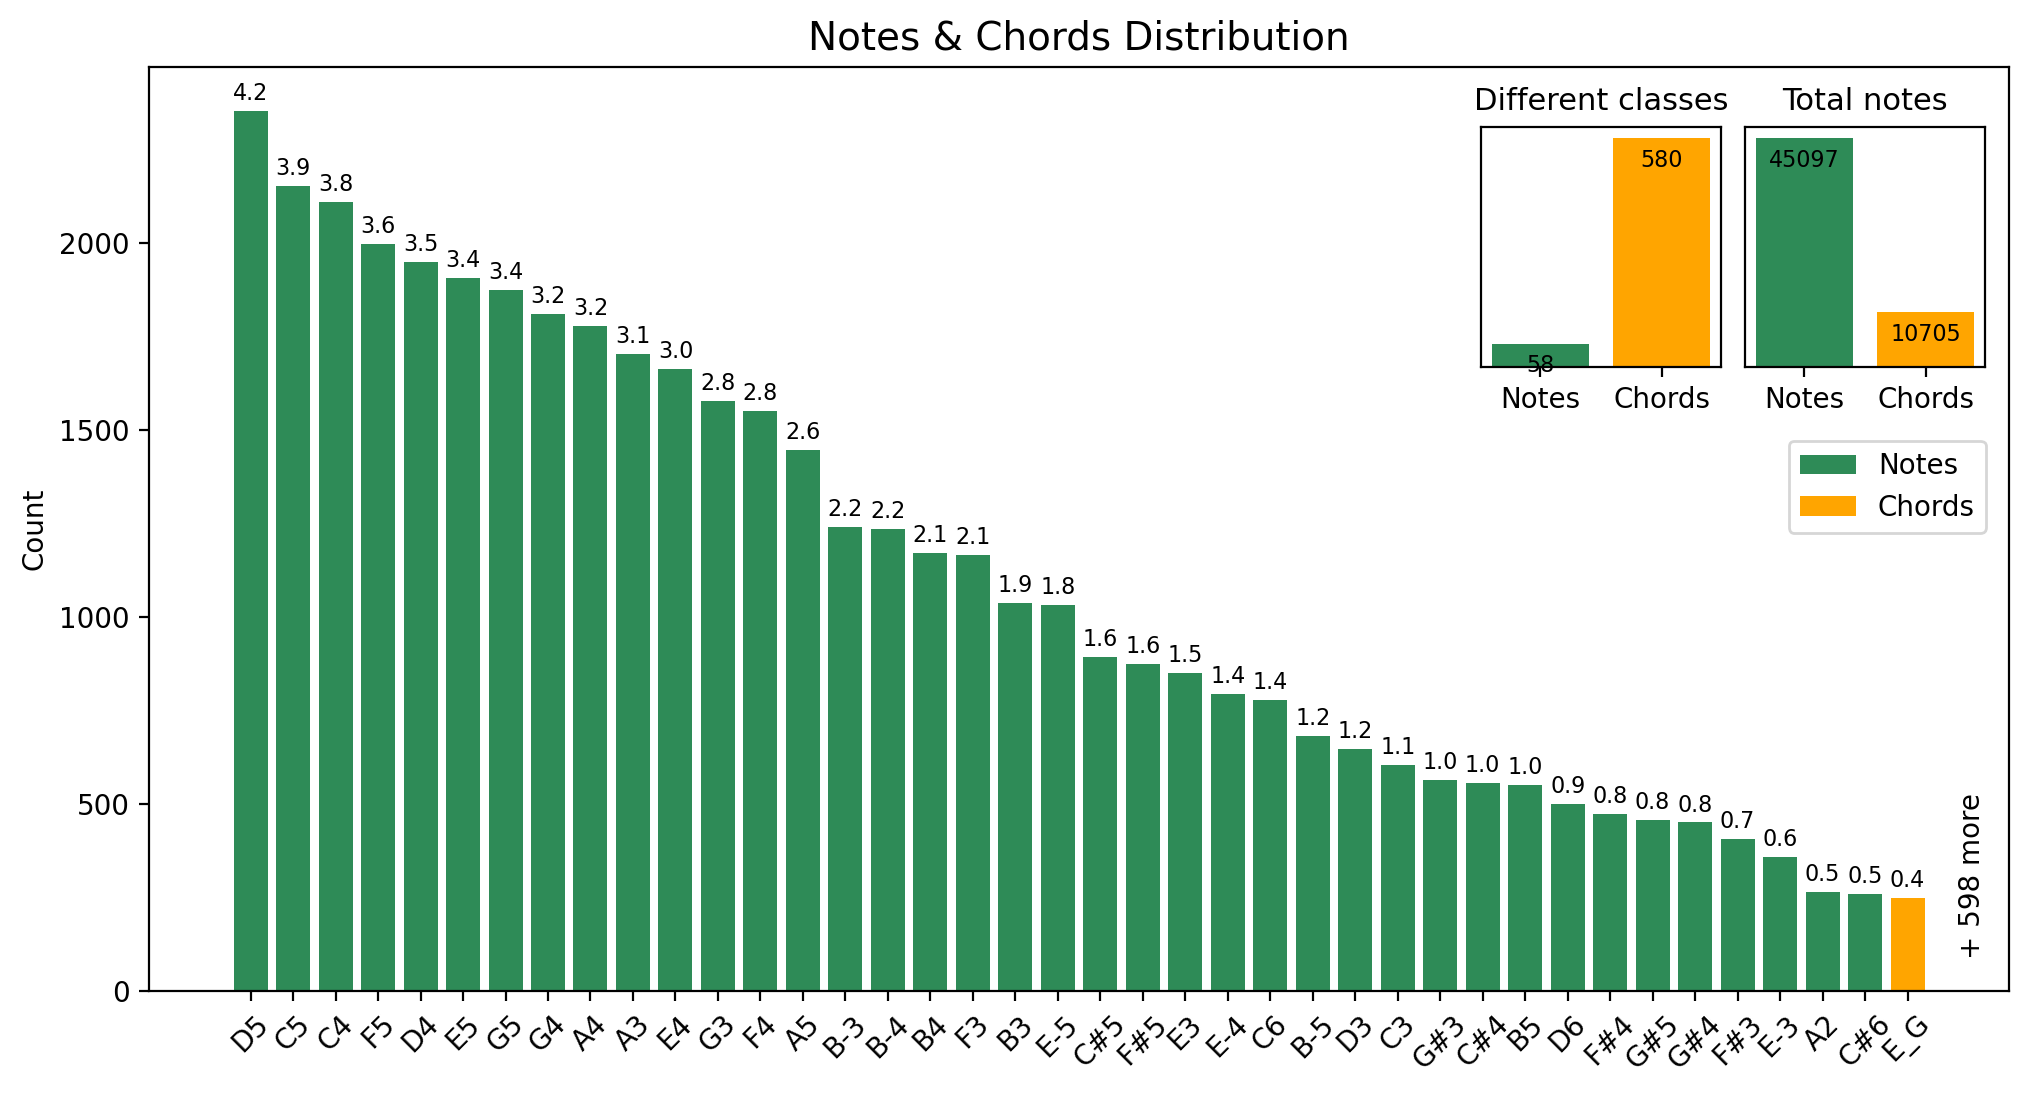

In [46]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import Counter
%matplotlib inline

def plot_notes(notes_list, max_bars=40, chord_marker="_"):
    sorted_notes = Counter(notes_list).most_common()
    notes, counts = [val[0] for val in sorted_notes], [val[1] for val in sorted_notes]
    
    # General plot elements
    plt.figure(figsize=(12, 6))
    plt.bar(notes[:max_bars], counts[:max_bars], color=["orange" if chord_marker in val else "seagreen" for val in notes])
    plt.title("Notes & Chords Distribution", fontsize=14)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    # Print info that plot was cut
    if max_bars < len(notes):
        plt.text(40.2, 100, f"+ {len(notes) - max_bars} more", rotation=90)
    
    # Print percentage
    for x, y in zip(notes[:max_bars], counts[:max_bars]):
        plt.text(x, y + max(counts[:max_bars])/80, f"{(y / sum(counts) * 100):.1f}", ha="center", fontsize=8)
    
    # Legend
    legend_elements = [Patch(facecolor='seagreen', label='Notes'), Patch(facecolor='orange', label='Chords')]
    plt.legend(handles=legend_elements, bbox_to_anchor=(.995, .61))
    
    # Side plots 
    total_notes = [counts[i] for i in range(len(notes)) if chord_marker not in notes[i]]
    total_chords = [counts[i] for i in range(len(notes)) if chord_marker in notes[i]]
    
    num_plt = plt.axes([0.79, 0.63, 0.1, 0.2])
    num_plt.bar(["Notes", "Chords"], [sum(total_notes), sum(total_chords)], color=["seagreen", "orange"])
    num_plt.set_yticks([])
    num_plt.set_title("Total notes", fontsize=11)
    for x, y in zip(["Notes", "Chords"], [sum(total_notes), sum(total_chords)]):
        num_plt.text(x, y - max([sum(total_notes), sum(total_chords)])/8, str(y), ha="center", fontsize=8)
    
    per_plt = plt.axes([0.68, 0.63, 0.1, 0.2])
    per_plt.bar(["Notes", "Chords"], [len(total_notes), len(total_chords)], color=["seagreen", "orange"])
    per_plt.set_yticks([])
    per_plt.set_title("Different classes", fontsize=11)
    for x, y in zip(["Notes", "Chords"], [len(total_notes), len(total_chords)]):
        per_plt.text(x, y - max([len(total_notes), len(total_chords)])/8, str(y), ha="center", fontsize=8)
    
    plt.show()
    
plot_notes(all_files_notes)

<font color="blue"><h5>FUNCTION: Limit number of notes</h5></font>
The function takes in a list of notes and optional durations and only keeps the most frequent notes. The cut off point can be changed. 
* `notes` = a list of notes, chords and pauses
* `durations` = an optional list containing the duration for each element in the notes list
* `limit` = The number of classes/different notes the input data is cut to

In [47]:
def limit_different_notes(notes, durations=None, limit=100):
    included_notes = [val[0] for val in Counter(notes).most_common()[:limit]]
    clipped_notes, clipped_durations = [], []

    for i in range(len(notes)):
        if notes[i] in included_notes:
            clipped_notes.append(notes[i])
            if durations is not None:
                clipped_durations.append(durations[i])

    print(f"Removed {len(notes) - len(clipped_notes)} notes to get to {len(set(clipped_notes))} classes ({len(clipped_notes)} total notes remaining)")
    return clipped_notes, clipped_durations

Removed 4300 notes to get to 100 classes (51502 total notes remaining)


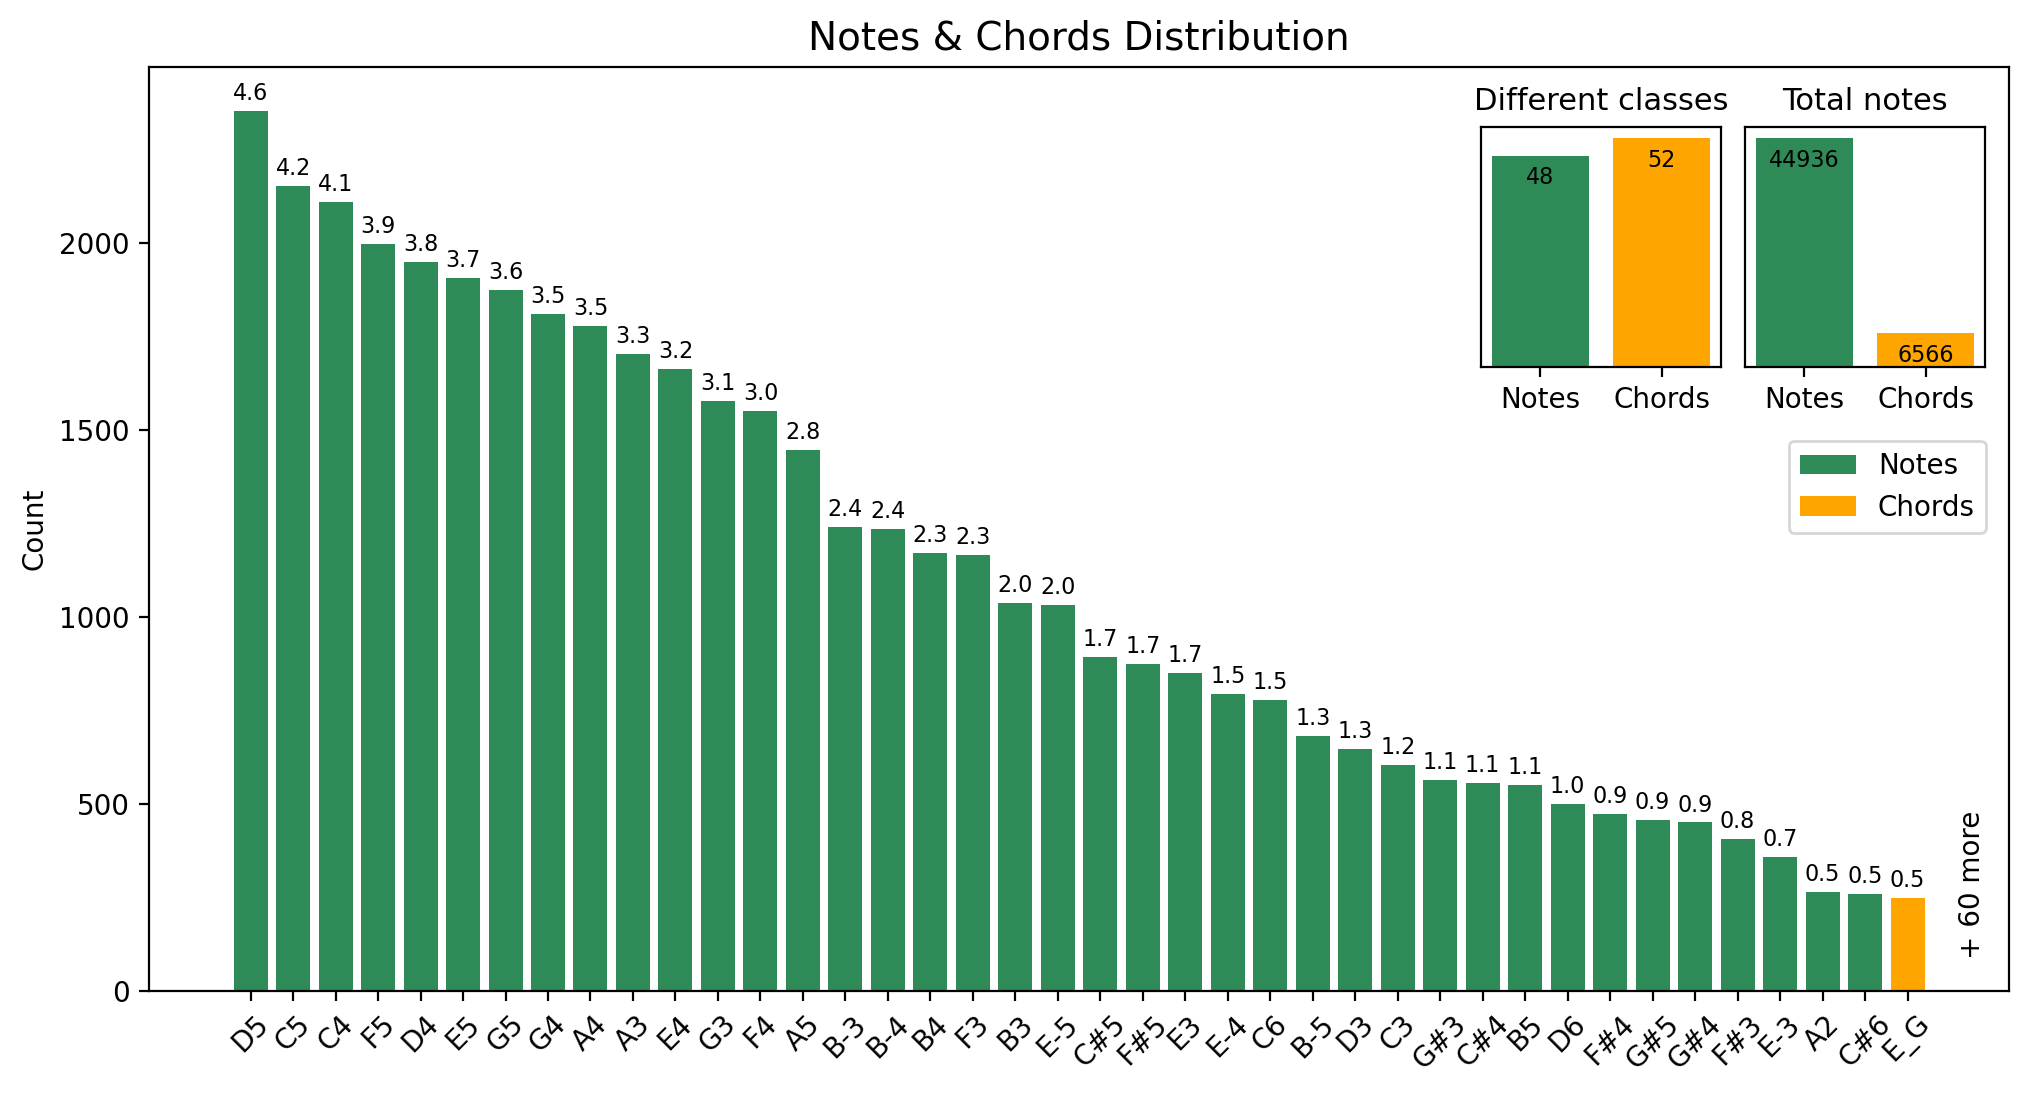

In [48]:
clipped_notes, clipped_durations = limit_different_notes(all_files_notes, all_files_durations)
plot_notes(clipped_notes)

## Create training data

We train the network to predict the next note or chord after it has seen a sequence of previous tones. Therefore, each input element is a sequence of tones and the label is the next note or chord followed by this sequence.

Until now, each tone is represented by a string. For the output, this representation needs to be converted to one-hot encoded vectors to be able to train the model using categorical cross-entropy. The input needs to be mapped to floats in $[0,1|$ that are used as input to the network.

<img alt="preprocess" src="data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%20standalone%3D%22no%22%3F%3E%0D%0A%3C%21DOCTYPE%20svg%20PUBLIC%20%22-%2F%2FW3C%2F%2FDTD%20SVG%201.1%2F%2FEN%22%20%22http%3A%2F%2Fwww.w3.org%2FGraphics%2FSVG%2F1.1%2FDTD%2Fsvg11.dtd%22%3E%0D%0A%3Csvg%20width%3D%22100%25%22%20height%3D%22100%25%22%20viewBox%3D%220%200%202953%20591%22%20version%3D%221.1%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%20xml%3Aspace%3D%22preserve%22%20xmlns%3Aserif%3D%22http%3A%2F%2Fwww.serif.com%2F%22%20style%3D%22fill-rule%3Aevenodd%3Bclip-rule%3Aevenodd%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke-miterlimit%3A1.5%3B%22%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C965.827%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1068.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1045.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3ED4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1150.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1130.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1232.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1209.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1314.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1292.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EE4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1396.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1374.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1478.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1456.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1560.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1531.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1232.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1209.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1314.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1292.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EE4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1396.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1374.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1478.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1456.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1560.83%2C96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28166%2C219%2C223%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1531.83%2C118%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1642.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1609.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF%234%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1314.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1292.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EE4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1396.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1374.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1478.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1456.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1560.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1531.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1642.83%2C236%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28166%2C219%2C223%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1609.83%2C258%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF%234%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1724.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1701.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC%23%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1396.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1374.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1478.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1456.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1560.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1531.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB-4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1642.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1609.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EF%234%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1724.83%2C376%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28166%2C219%2C223%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1701.83%2C398%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EC%23%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1806.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1784.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1888.83%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%2284.35%22%20y%3D%2246.521%22%20width%3D%2282.01%22%20height%3D%2282.01%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3Bstroke%3Ablack%3Bstroke-width%3A1px%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1866.83%2C-22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22115.625px%22%20y%3D%2283.587px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A50px%3B%22%3EB5%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M331.35%2C186.521L331.36%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M659.35%2C186.521L659.35%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M413.35%2C326.521L413.35%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M741.35%2C326.521L741.35%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M495.36%2C466.414L495.35%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M823.36%2C466.414L823.36%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C985.827%2C-44%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M905.36%2C466.521L905.36%2C128.531%22%20style%3D%22fill%3Anone%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-dasharray%3A3%2C3%2C0%2C0%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C1601.35%2C-303.498%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C1683.35%2C-163.498%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.50007%2C0%2C0%2C1%2C1765.35%2C-23.4975%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M275.736%2C494.2L275.736%2C479.848L374.611%2C479.848L374.611%2C466.521L415.61%2C487.024L374.611%2C507.526L374.611%2C494.2L275.736%2C494.2Z%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1103.37%2C6.19147%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3EX%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C437.584%2C-364.362%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Eseq%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22602.974px%22%20y%3D%22590.044px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A36.438px%3B%22%3E4%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C383.584%2C-514.362%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Enotes%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C437.584%2C-234.362%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Eseq%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22602.974px%22%20y%3D%22590.044px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A36.438px%3B%22%3E5%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C437.584%2C-94.3615%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Eseq%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22602.974px%22%20y%3D%22590.044px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A36.438px%3B%22%3E6%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%28-0.00034298%2C1%2C-1%2C-0.00034298%2C1573.35%2C-16.572%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3E...%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%28-0.00034298%2C1%2C-1%2C-0.00034298%2C1570.03%2C-421.634%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3E...%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1314.37%2C6.19147%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22517.599px%22%20y%3D%22569.231px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A62.5px%3B%22%3Ey%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.00023754%2C0.71323%2C-4.12755%2C0.00137467%2C4031.46%2C247.776%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22353.101px%22%20y%3D%22598.079px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A79.542px%3B%22%3E%7D%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.00023754%2C0.71323%2C-1.03072%2C0.000343278%2C2446.05%2C248.332%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22353.101px%22%20y%3D%22598.079px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A79.542px%3B%22%3E%7D%3C%2Ftext%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%3C%2Fsvg%3E%0D%0A" />

#### Tasks: 
* Create the training elements by following the *shifting* procedure depicted above
* normalize the input sequences to $[0,1|$ and one-hot encode the labels

#### Hints:
* Use a sequence length of ~50-100 notes
* create a mapping from the string-representation of a tone to an int and vice versa
* use [```keras.utils.to_categorical```](https://keras.io/api/utils/python_utils/#tocategorical-function) to convert an integer to a one-hot vector

<font color="blue"><h5>FUNCTION: Creation of the Note to Integer mapping</h5></font>
This function takes in a list of notes and assigns each different note an integer value for later use in training data normalization as well as the one hot encoding of the labels.
* `notes_list` = a list of notes, chords and pauses
* `int_to_note` = If true, creates the mapping reversed. Instead of note names being the key, The integer is the key and note name the value. 

In [49]:
def create_note_to_int_mapping(notes_list, int_to_note=False):
    notes_map = {}
    for i, note in enumerate(set(notes_list)):
        if int_to_note:
            notes_map[i] = note
        else:
            notes_map[note] = i
        
    return notes_map

In [50]:
note_mapping = create_note_to_int_mapping(clipped_notes)
print(note_mapping)

{'B-5': 0, 'F#5': 1, 'G4': 2, 'E_G': 3, 'E-5': 4, 'E4': 5, 'A3': 6, 'F_G': 7, 'B-4': 8, 'C#5': 9, 'A_C': 10, 'F2': 11, 'G#5': 12, 'B4': 13, 'F3': 14, 'C_E-': 15, 'C_E': 16, 'A_F': 17, 'D_F#': 18, 'G_F': 19, 'D6': 20, 'D_C': 21, 'E6': 22, 'F#4': 23, 'A_F#': 24, 'D5': 25, 'G_D': 26, 'C_A': 27, 'G#4': 28, 'A2': 29, 'A_B': 30, 'E_D': 31, 'C3': 32, 'D_B-': 33, 'F_A': 34, 'C#4': 35, 'G2': 36, 'G_A': 37, 'B5': 38, 'G_B': 39, 'B2': 40, 'B-_B-': 41, 'C_B-': 42, 'E_C': 43, 'C#_A': 44, 'A4': 45, 'D_F': 46, 'C#6': 47, 'D4': 48, 'D_D': 49, 'B-3': 50, 'C_C': 51, 'E-6': 52, 'E_A': 53, 'B-_D': 54, 'C6': 55, 'D_B': 56, 'D3': 57, 'E-4': 58, 'E3': 59, 'G_B-': 60, 'G_E-': 61, 'F_D': 62, 'F#3': 63, 'E2': 64, 'F_G#': 65, 'G_G': 66, 'B_B': 67, 'C_G': 68, 'B-2': 69, 'C#3': 70, 'C_D': 71, 'F4': 72, 'A_C#': 73, 'B-_G': 74, 'G_E': 75, 'B3': 76, 'E-_C': 77, 'G_C': 78, 'E_C#': 79, 'E-_G': 80, 'C4': 81, 'E5': 82, 'E-3': 83, 'G#3': 84, 'B_D': 85, 'G5': 86, 'A_A': 87, 'F5': 88, 'F6': 89, 'E_E': 90, 'A5': 91, 'D_E': 9

<font color="blue"><h5>FUNCTION: Creation of the training data</h5></font>
In this function, sequences of notes are created from the data. The training sequences get normalized and the label, which is the note right after each sequence, is getting one hot encoded.the function returns the training data as a dictionary separated into input and label, and returns the created mapping of notes to integers. The return of the mappings is needed for later conversion back to readable notes.
* `notes_list` = a list of notes, chords and pauses
* `seq_length` = The length of one training sequence

In [51]:
def create_training_data(notes_list, seq_length=50):
    note_to_int_mapping = create_note_to_int_mapping(notes_list)
    train_data = {"input": [], "label": []}
    
    for i in range(len(notes_list))[:-(seq_length+1)]:
        seq = notes_list[i:i+seq_length]
        int_seq = [note_to_int_mapping[val] for val in seq]
        norm_seq = [val/len(note_to_int_mapping) for val in int_seq]
        train_data["input"].append(norm_seq)
        
        label_one_hot_enc = tf.keras.utils.to_categorical(note_to_int_mapping[notes_list[i+seq_length+1]], num_classes=len(note_to_int_mapping))
        train_data["label"].append(label_one_hot_enc)
        
    return train_data, note_to_int_mapping

In [52]:
data, note_to_int_mapping = create_training_data(clipped_notes)
print(f"Created training dataset with {len(data['input'])} entries")

Created training dataset with 51451 entries


#### Split & Reshape Train/Test Data

<font color="blue"><b>Comment:</b></font> We wrapped the `train_test_split` function of sklearn into a separate function to also include reshaping of the data to the required input shape of keras LSTM layers.

In [53]:
from sklearn.model_selection import train_test_split
import numpy as np

def train_test_split_and_reshape(training_data_dict, test_size=0.2, verbose=True):
    X_train, X_test, y_train, y_test = train_test_split(np.array(training_data_dict["input"]), np.array(training_data_dict["label"]), test_size=test_size)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    if verbose:
        print(f"X_train: {X_train.shape} | y_train: {y_train.shape} | X_test: {X_test.shape} | y_test: {y_test.shape}")

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_and_reshape(data)

X_train: (41160, 50, 1) | y_train: (41160, 100) | X_test: (10291, 50, 1) | y_test: (10291, 100)


## Create and train the VAE

<font color="blue"><b>Comment:</b></font> We decided to create a function for creating the model to be able to quickly change out the architecture parameters.

In [54]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import losses

In [55]:
# Global Variables
batch_size = 100
original_dim = 1000
latent_dim = 2
intermediate_dim = 32
epochs = 10
epsilon_std = 1.0

In [56]:
# Encoder needs dimension of latent, intermediate and original distribution
def create_encoder(batch_size, original_dim, latent_dim, intermediate_dim, epochs, epsilon_std):
    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)
    z_means = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)
    return x, h, z_means, z_log_var

# Testing the encoder model
x, h, z_means, z_log_var = create_encoder(batch_size, original_dim, latent_dim, intermediate_dim, epochs, epsilon_std)
encoderModel = Model(inputs=x, outputs=[z_means, z_log_var], name='Encoder Model')
encoderModel.summary()

Model: "Encoder Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 1000)]       0                                            
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 32)           32032       input_13[0][0]                   
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 2)            66          dense_44[0][0]                   
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 2)            66          dense_44[0][0]                   
Total params: 32,164
Trainable params: 32,164
Non-trainable params: 0
________________

### Sampling
<font color="blue"><b>Comment:</b></font> Function for sampling a Gaussian Distribution. Epsilon must be multiplied with the standard-deviation and added to mean.

In [57]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [58]:
# Lambda Layer for implementing the sampling function in keras#
z = Lambda(sampling, output_shape=(latent_dim,))([z_means, z_log_var])

### Decoder Model

In [59]:
# Decoder needs dimensions of latent and intermediate distribution 
def create_decoder(latent_dim, intermediate_dim):
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)
    
    return decoder_h, decoder_mean, h_decoded, x_decoded_mean

decoder_h, decoder_mean, h_decoded, x_decoded_mean = create_decoder(latent_dim, intermediate_dim)

### Complete VAE

In [63]:
vae = Model(x, x_decoded_mean, name='Decoder Model')
vae.summary()

Model: "Decoder Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 1000)]       0                                            
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 32)           32032       input_13[0][0]                   
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 2)            66          dense_44[0][0]                   
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 2)            66          dense_44[0][0]                   
______________________________________________________________________________________

### Custom Loss

<font color="blue"><b>Comment:</b></font> For gradient descent, two losses are needed. The KL divergence and the Reconstruction loss, that is the reconstruction of the original input. The Network can be then trained by minimizing the recostruction error.

In [66]:
class kl_divergence_layer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(kl_divergence_layer, self).__init__(**kwargs)
    
    @tf.function
    def vae_loss(self, x, x_decoded_mean):
        x_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean) # Reconstruction Loss
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_means) - K.exp(z_log_var), axis=-1) # Regularisation
        return K.mean(x_loss + kl_loss)
    
    @tf.function
    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        return x

In [67]:
y = kl_divergence_layer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

### Training VAE

In [73]:
# Data is already split into trainings- and test-data
# X_train, X_test, y_train, y_test
hist = vae.fit(X_train, epochs=epochs, batch_size=batch_size, X_test)

SyntaxError: positional argument follows keyword argument (1466096403.py, line 3)

In [72]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
max_val_acc=  np.max(val_loss)
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,8))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

NameError: name 'hist' is not defined

<font color="blue"><h5>CLASS: Training Callback</h5></font>
A Callback class used during training that inherits from the keras Callback class. Its purpose is to display a plot with relevant metrics (Loss, Accuracy) and concrete current metric values. The user can specify how often the plot is drawn with the `plot_every_x_epochs` parameter.

In [82]:
class PerfPlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, plot_every_x_epochs=10):
        super().__init__()
        self.train_loss = []
        self.test_loss = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.plot_every_x_epochs = plot_every_x_epochs
        
    @tf.function
    def on_epoch_end(self, epoch, logs=None):
        self.train_loss.append(logs["loss"])
        self.test_loss.append(logs["val_loss"])
        self.train_accuracy.append(logs["accuracy"])
        self.test_accuracy.append(logs["val_accuracy"])
        
        if epoch % self.plot_every_x_epochs == 0 and epoch != 0:
            fig = plt.figure(figsize=(8, 2), dpi=100)
            fig.suptitle(f"Model Performance after Epoch {epoch}", y=1.1)
            plt.figtext(.92, .5, f"Training Loss: {round(logs['loss'], 2)}\nValidation Loss: {round(logs['val_loss'], 2)}\n\nTraining Accuracy: {round(logs['accuracy'], 2)}\nValidation Accuracy: {round(logs['val_accuracy'], 2)}")
            
            plt.subplot(1, 2, 1)
            plt.title("Model Loss", fontsize=11)
            plt.plot(self.train_loss, color="seagreen", label="Training")
            plt.plot(self.test_loss, color="orange", label="Validation")
            plt.legend()
            plt.xlabel("Epoch")
            
            plt.subplot(1, 2, 2)
            plt.title("Model Accuracy", fontsize=11)
            plt.plot(self.train_accuracy, color="seagreen", label="Training")
            plt.plot(self.test_accuracy, color="orange", label="Validation")
            plt.xlabel("Epoch")
            
            plt.show()

<font color="blue"><h5>FUNCTION: Main Training</h5></font>
We created a main training function that includes all previously defined functions in order to run a complete model training including acquiring data, transforming the data, creating training and test partitions, creating and compiling a new model, and training the model. This was done so we can quickly change and test new training data or model hyperparameter. For each training, the best model weights according to validation accuracy are saved.<br>
The function needs the following parameters:
* `midi_files` = The folder path to the midi files intended for training
* `max_classes` = The maximum amount of different notes/chords. If more classes are in the data, the least used get cut
* `input_length` = The length of one training sequence
* `only_first_part` = Refers to the midi file parsing. If true, only the first part (Erste Stimme) is used<br>

Optionally the parameters `num_lstm_layers`, `lstm_units`, `learning_rate`, `batch_size`, `epochs`, and `plot_every_x_epochs` can be configured for better model tuning. <br>

Additionaly, the parameter `preloaded_notes_and_durations` was introduced to reduce training time when not switching between different training data. This will overwrite the `midi_files` parameter and will use the already extracted notes given as input.


<font color="blue"><b>Comment:</b></font> Instead of complete lstm_training, the function changed for training a VAE. The changes particularely take place in the building of the model.

In [83]:
#ToDo 
def complete_vae_training(midi_files, max_classes, input_length, 
                           learning_rate=0.01, batch_size=32, epochs=10, plot_every_x_epochs=10,
                           only_first_part=False, preloaded_notes_and_durations=None):
    
    # Get & transform data
    print(">> Creating training data")
    if preloaded_notes_and_durations is None:
        all_files_notes, all_files_durations = extract_notes_from_midi_files(midi_files, flatten_list=True, only_first_part=only_first_part)
    else:
        all_files_notes, all_files_durations = preloaded_notes_and_durations
        print("Loaded notes and durations from given list")
    
    # Preprocessing of the data
    clipped_notes, clipped_durations = limit_different_notes(all_files_notes, all_files_durations, limit=max_classes)
    data, note_to_int_mapping = create_training_data(clipped_notes, seq_length=input_length)
    X_train, X_test, y_train, y_test = train_test_split_and_reshape(data, verbose=True)
    plot_notes(clipped_notes)
    
    # Build model
    print("\n>> Building model")    
    # batch_size, original_dim, latent_dim, intermediate_dim, epochs, epsilon_std
    create_encoder(batch_size, original_dim, latent_dim, intermediate_dim, epochs, epsilon_std)
    create_decoder(latent_dim, intermediate_dim)
    y = kl_divergence_layer()([x, x_decoded_mean])
    model = Model(x, y)
    model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=['accuracy'])
    
    # Training
    print("\n>> Beginning training")
    train_start_time = time.time()
    checkpoint_path = "./checkpoint_data/" + datetime.now().strftime('%d_%m_%Y_%H_%M')
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_test, y_test), 
              callbacks=[PerfPlotCallback(plot_every_x_epochs), tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True, save_freq="epoch")])
    
    # Finish
    print("\n>> Finished training")
    print(f"Total training time: {round((time.time() - train_start_time)/60)} minutes")
    print("Final training Loss:", model.history.history["loss"][-1])
    print("Final validation Loss:", model.history.history["val_loss"][-1])
    print("Final training Accuracy:", model.history.history["accuracy"][-1])
    print("Final validation Accuracy:", model.history.history["val_accuracy"][-1])

    # Model and relevant training information get returned as a dict
    return {"model": model, "mappings": note_to_int_mapping, "train_data": X_train}
    

>> Creating training data
Loaded notes from 102 midi files
Total number of notes: 4618
Number of unique notes: 36
Removed 0 notes to get to 36 classes (4618 total notes remaining)
X_train: (3665, 35, 1) | y_train: (3665, 36) | X_test: (917, 35, 1) | y_test: (917, 36)


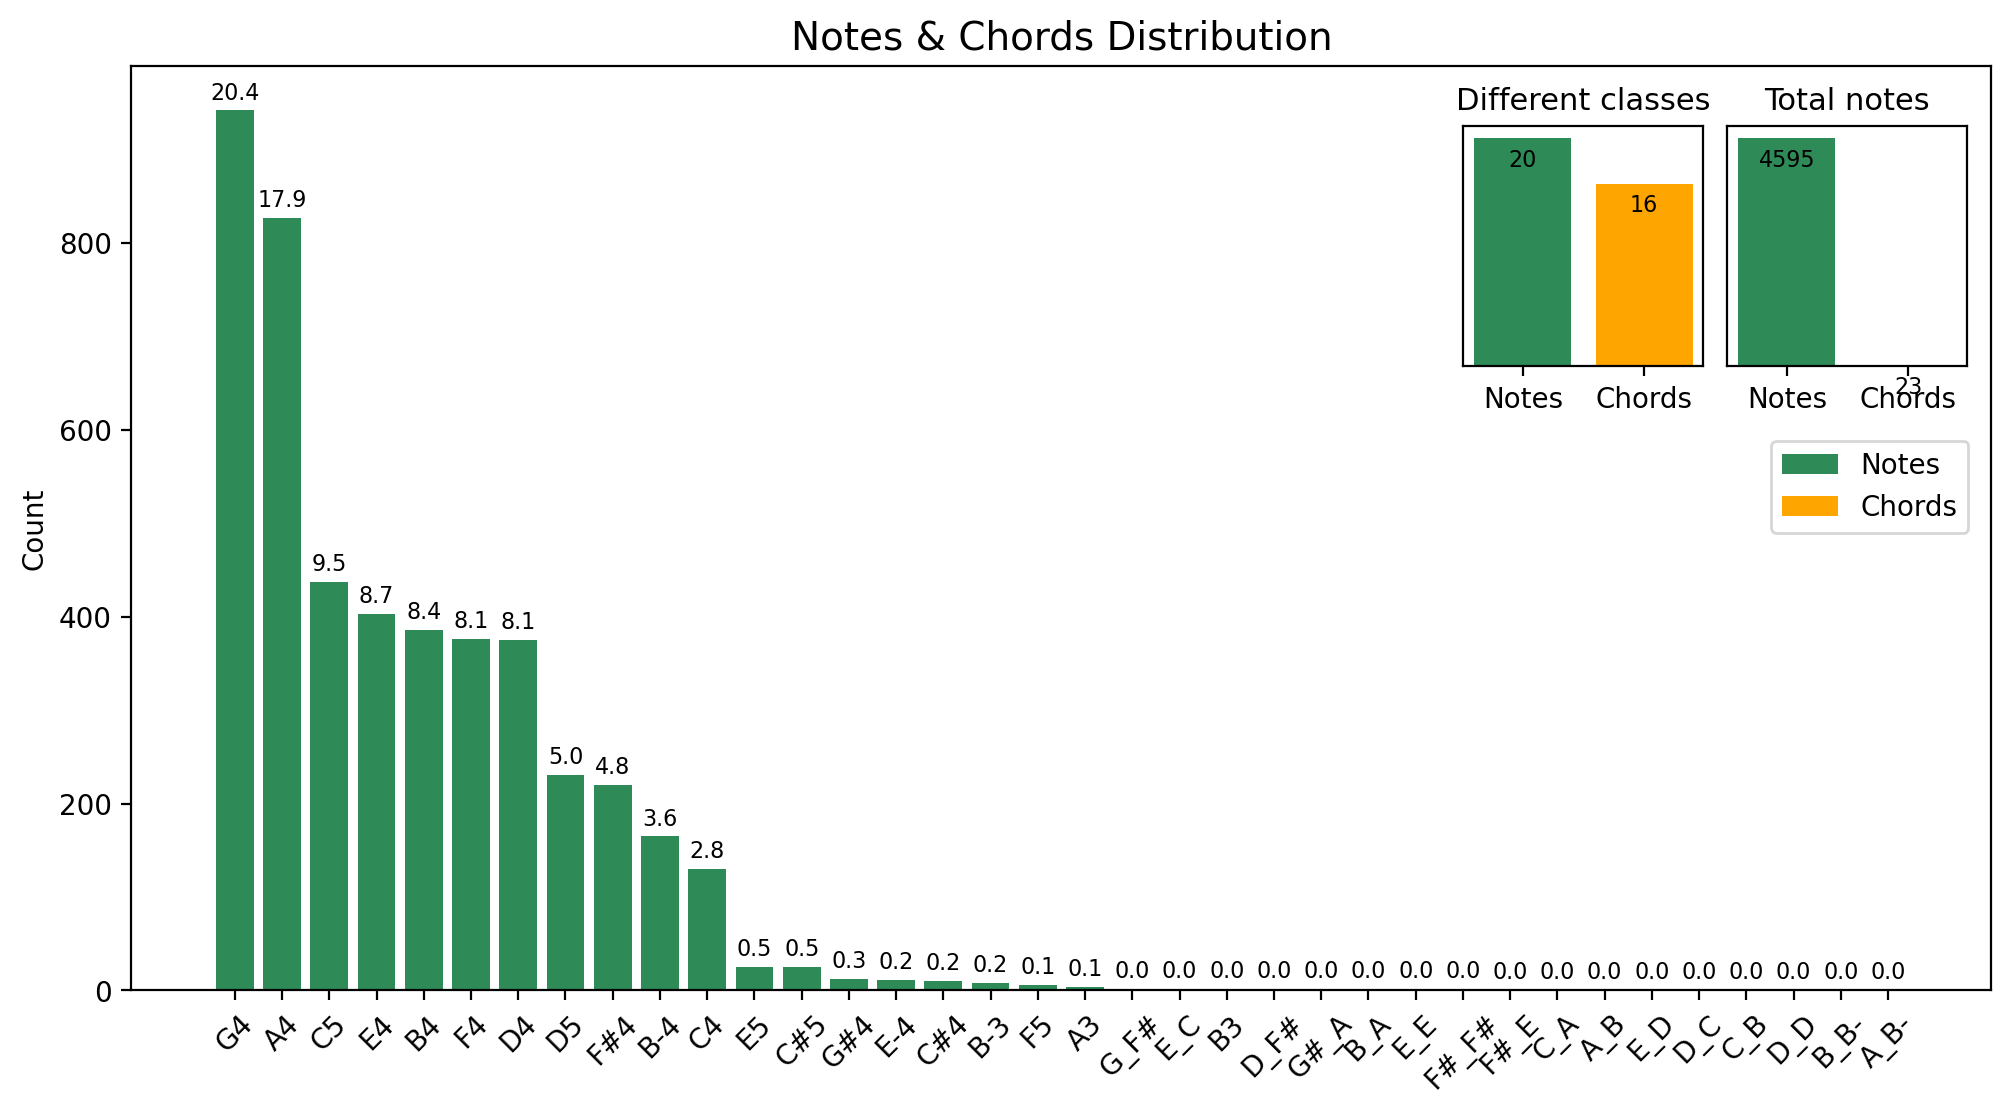


>> Building model

>> Beginning training


/opt/miniconda3/envs/myenv3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2023-05-09 09:51:49.180385: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-09 09:51:49.282492: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2649995000 Hz


ValueError: Input 0 is incompatible with layer model_5: expected shape=(None, 1000), found shape=(256, 35, 1)

In [84]:
training_output = complete_vae_training("midi_files/kids_songs", max_classes=100, input_length=35, batch_size=256, plot_every_x_epochs=100, 
                                         epochs=1001, learning_rate=0.0003, only_first_part=True)

trained_model = training_output["model"]
note_to_int_mapping = training_output["mappings"]
training_data = training_output["train_data"]

# trained_model.save('saved_models')

# Generating new Music

<font color="blue"><h5>FUNCTION: Generate new music</h5></font>
This function creates new music tracks by performing looped inference on a trained model. Returns a list of note names. The initial sequence is also returned in a converted state if the user wants to combine the two sequences to see how the generated music differs from its input sequence.
* `model` = A trained keras model used for inference
* `start_sequence` = The start sequence for the inference. Needs to be a normalised note sequence. Reshaping is handeled by the function if necessary
* `note_to_int_mapping` = The mapping used in the creating of the training data for the model
* `length` = The number of notes the new track should contain

In [ ]:
def generate_new_music(model, start_sequence, note_to_int_mapping, length):
    int_to_note_mapping = {y: x for x, y in note_to_int_mapping.items()}  # Flip mapping for easier use
    generated_sequence = []  # List for storing generated notes
    num_classes = model.layers[0].input_shape[1]  # Get number of classes by looking at model input
    
    # Reshape input sequence if necessary
    if len(start_sequence.shape) != 3:
        start_sequence = start_sequence[:num_classes].reshape(1, num_classes, 1)
    moving_sequence = copy.deepcopy(start_sequence)

    # Model Inference = Create music
    for i in range(length):
        prediction = model.predict([moving_sequence])[0].tolist()
        pred_note_name = int_to_note_mapping[prediction.index(max(prediction))]
        moving_sequence = np.delete(moving_sequence, 0, axis=1) # Remove first element
        pred_norm = note_to_int_mapping[pred_note_name]/num_classes
        moving_sequence = np.append(moving_sequence, np.array([[pred_norm]]).reshape(1, 1, 1), axis=1)
        generated_sequence.append(pred_note_name)

    # Convert input sequence
    start_seq_flat = np.ndarray.flatten(start_sequence*num_classes)
    start_seq_flat = start_seq_flat.astype(int)
    start_seq_notes = [int_to_note_mapping[i] for i in start_seq_flat]
        
    return start_seq_notes, generated_sequence

In [ ]:
input_sequence = random.choice(training_data)  # Use a random training sequence as input
start_sequence, generated_sequence = generate_new_music(trained_model, input_sequence, note_to_int_mapping, length=500)

print("Input Sequence:\n", start_sequence)
print("Generated Sequence:\n", generated_sequence)

You can now use the ```show()``` method of the stream to listen to the generated masterpiece or save it to disk for later enjoyment using the ```write()``` method.

<font color="blue"><b>Comment:</b></font> The function for converting note names back to a Stream object was already defined in a previous cell in this notebook, because we wanted to make sure the notes were extracted correctly. See function `create_midi`.

In [ ]:
# Create Midi
# generated_stream = create_midi(start_sequence + generated_sequence)
generated_stream = create_midi(generated_sequence)
generated_stream.show("midi")

# Save as file
generated_stream.write("midi", f"./generated_music/track_{datetime.now().strftime('%d_%m_%Y_%H_%M')}.mid")

<font color="blue"><h2>Final Conclusion</h2></font>

ToDo